In [5]:
import findspark
import pyspark
import numpy as np
import pyspark.sql.functions as sqlFunctions
import matplotlib.pyplot as plt

from operator import add
from pyspark.sql import SQLContext

%matplotlib inline

In [6]:
findspark.init()
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

In [7]:
# Full original training set
raw_full_train = sc.textFile("dac/train.txt")

# Final test set split
raw_final_test = sc.textFile("dac/split/test.txt")  # Do not touch during training

# Training set splits
raw_test_3m = sc.textFile("dac/split/test_3m.txt")
raw_train_5m = sc.textFile("dac/split/train_5m.txt")
raw_validation_2m = sc.textFile("dac/split/train_5m.txt")

# Debug set
raw_small_train = sc.textFile("dac/small-train.txt")

In [8]:
def convert_value(index, value):
    if index < 14:
        return int(value) if value else None
    else:
        return value if value else None

def convert_line(line):
    return [convert_value(i, value) for i, value in enumerate(line.split("\t"))]

In [9]:
# Change the data types of the datasets so that the RDD's include Int's and Strings. 
full_train = raw_full_train.map(convert_line)
final_test = raw_final_test.map(convert_line)
test_3m = raw_test_3m.map(convert_line)
train_5m = raw_train_5m.map(convert_line)
validation_2m = raw_validation_2m.map(convert_line)

#debug = raw_small_train.map(convert_line)

In [10]:
def int_column_histogram(col_num, col,numb_bins=10):
    bins, counts = col.histogram(numb_bins)
    total = sum(counts)    
    print "Column %d histogram\n\tBins=%s\n\tCounts=%s (total=%d)" % (col_num, bins, counts, total)
    # TODO: display graph of histogram
    # TODO: better buckets for histogram (smart sub-dividing)
        #sum the counts
        #max of the counts
        #if  > 25%
    return bins,counts

def int_columns_histograms(data):
    bins=[]; counts=[]
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_integer_col_num(col_num):
            bins1,counts1 = int_column_histogram(col_num, col)
            bins.append(bins1) #bin values
            counts.append(counts1) #count inside bins
            
    return bins,counts

def bin_range_labels(bins):
    #Nicely display these.
    "{:0,.3f} - {:0,.0f}"
    return ["%s---%s" % ("{:.1E}".format((bins[i])),"{:.2E}".format((bins[i+1]))) for i in range(len(bins) - 1)]




In [11]:
def get_column_num(data, col_num):
    return data.map(lambda row: row[col_num])

def column_filter_null(column):
    return column.filter(lambda row: row is not None)

def column_count(data):
    return len(data.take(1)[0])

def is_integer_col_num(col_num):
    return col_num > 1 and col_num < 15

def is_label_col_num(col_num):
    return col_num == 1

def is_categorical_col_num(col_num):
    return col_num >= 15

def column_iter(data):
    for i in range(column_count(data)):
         yield get_column_num(data, i)

In [12]:
def cat_columns_histogram(data,numb_bins=10):
    hashes=[]; counts_all=[]; remainder=[];
    
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_categorical_col_num(col_num):
            key_counts = col.map(lambda key: (key, 1)).reduceByKey(add)
            sorted_counts = sorted(key_counts.collect(), key=lambda t: t[1], reverse=True)
            labels = [v[0] for v in sorted_counts]
            counts = [v[1] for v in sorted_counts]
            print i
            print col
            hashes.append(labels[:numb_bins]) #bin values
            counts_all.append(counts[:numb_bins]) #count inside bins
            remainder.append(sum(counts[numb_bins:]))
            
    return hashes,counts_all,remainder

In [13]:
# This represents the Histograms for Features. 
# For Integer Feature we do not compute "Other Values"
# 
# x_values = 1D array of the x_values {bins OR category names}
# y_values = 1D array of the y_values {counts of uniques in bins or category name}
# isCategory = True if feature is category. 
#            = False if feature is integer.
# Z_other_values = sum of the counts of the remaining categories for category feature.
#
#
def disp_Histogram(x_values,y_values,isCategory, column_numb,z_other_value=0):
        range_x = min(len(x_values),10)
        x1 = np.arange(range_x)
        x2 = []
        
        
        # Category Feature
        if (isCategory):
            type_of_feature = "Category"
            x_label = "Category as a Hashed value"
            #Add Other column
            for i in x_values: 
                x2.append(str(i))
            
            x1 = np.append(x1,10)
            x2.append('Other')
            #print "HI",z_other_value
            y_values.append(z_other_value)

        # Integer Feature
        else: 
            type_of_feature = "Integer"
            x_label = "Bins of Integer values"
            x2 = bin_range_labels(x_values)

        
        plt.title('%s Feature %s Histogram' % (type_of_feature,column_numb))
        plt.ylabel('Count of values')
        plt.xlabel('The %s' % x_label)
        print ("X: %s, Y: %s" % (x1,y_values))
        plt.xticks(x1, x2,rotation=45)
        print "X: %s, Y: %s" % (len(x1),len(y_values))
        plt.bar(x1, y_values,log=True)
        plt.show()

    

In [14]:
# The following shows all the histograms for all of the features. 
def show_all_histograms(x,y,featureType,z_other_value=0):
    isCategory = True
     
    if featureType=="Integer":
        isCategory = False
       
        for i in range(len(x)):
            disp_Histogram(x[i],y[i],isCategory,i,z_other_value=0)
    else:
        isCategory = True
        for i in range(len(x)):
            #print z_other_value[i]
            disp_Histogram(x[i],y[i],isCategory,i,z_other_value[i])




## This computes the Mean, StDev, Kurtosis, and Skewness for each Integer Feature. 

It outputs the results for 13 features.

In [15]:
def print_column_summary_details(col_num, mean,std,kurtosis, skewness):
    print("Column #%2d: mean=%-10.3f std=%-10.3f Kurtosis=%-10.3f Skewness=%-10.3f" % (col_num, mean,std, kurtosis, skewness))

def int_columns_detail_stats(data):
    df = sqlContext.createDataFrame(data)
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_integer_col_num(col_num):            
            col = df["_%s" % col_num]
            m_col = sqlFunctions.mean(col)
            m_results = df.select(m_col.alias("mean")).collect()[0]
            std_col = sqlFunctions.stddev(col)
            std_results = df.select(std_col.alias("stddev")).collect()[0]
            k_col = sqlFunctions.kurtosis(col)
            k_result = df.select(k_col.alias("kurtosis")).collect()[0]
            s_col = sqlFunctions.skewness(col)
            s_result = df.select(s_col.alias("skewness")).collect()[0]
            
            print_column_summary_details(col_num, m_results.mean,std_results.stddev,k_result.kurtosis, s_result.skewness)

### The following functions compute the Summary Statistics

In [31]:
#This code computes the histograms based on the training sets.
#The code computes 10 bins by default.

x_int_val, y_int_val =int_columns_histograms(train_5m)
show_all_histograms(x_int_val,y_int_val,"Integer")


Column 2 histogram
	Bins=[0.0, 234.4, 468.8, 703.2, 937.6, 1172.0, 1406.4, 1640.8, 1875.2, 2109.6, 2344]
	Counts=[2608370, 218, 27, 3, 2, 1, 0, 1, 0, 1] (total=2608623)
Column 3 histogram
	Bins=[-3.0, 25764.8, 51532.6, 77300.4, 103068.2, 128836.0, 154603.8, 180371.6, 206139.4, 231907.19999999998, 257675]
	Counts=[4774841, 1, 0, 0, 0, 0, 0, 0, 0, 1] (total=4774843)
Column 4 histogram
	Bins=[0.0, 6553.5, 13107.0, 19660.5, 26214.0, 32767.5, 39321.0, 45874.5, 52428.0, 58981.5, 65535]
	Counts=[3747338, 488, 123, 242, 143, 72, 10, 3, 3, 31] (total=3748453)
Column 5 histogram
	Bins=[0, 70, 140, 210, 280, 350, 420, 490, 560, 630, 700]
	Counts=[3737174, 1777, 92, 16, 20, 10, 4, 2, 2, 4] (total=3739101)
Column 6 histogram
	Bins=[0.0, 255726.4, 511452.8, 767179.2, 1022905.6, 1278632.0, 1534358.4, 1790084.8, 2045811.2, 2301537.6, 2557264]
	Counts=[4579573, 49120, 15590, 4201, 1673, 562, 307, 40, 33, 10] (total=4651109)
Column 7 histogram
	Bins=[0.0, 26334.8, 52669.6, 79004.4, 105339.2, 131674.0, 1

In [43]:
#Compute and display Integer Summary Statistics, Mean, Stdev, Skewness, Kurtosis)
int_columns_detail_stats(train_5m)

Column # 2: mean=3.506      std=9.487      Kurtosis=2467.921   Skewness=21.715    
Column # 3: mean=106.426    std=408.916    Kurtosis=33043.668  Skewness=58.625    
Column # 4: mean=26.907     std=406.856    Kurtosis=9174.424   Skewness=84.200    
Column # 5: mean=7.319      std=8.777      Kurtosis=91.283     Skewness=3.880     
Column # 6: mean=18504.251  std=69152.937  Kurtosis=123.590    Skewness=9.298     
Column # 7: mean=116.180    std=409.881    Kurtosis=128391.376 Skewness=218.617   
Column # 8: mean=16.351     std=66.729     Kurtosis=10468.553  Skewness=46.979    
Column # 9: mean=12.511     std=16.744     Kurtosis=14231.391  Skewness=66.134    
Column #10: mean=106.233    std=221.595    Kurtosis=259.332    Skewness=9.170     
Column #11: mean=0.617      std=0.684      Kurtosis=2.366      Skewness=1.129     
Column #12: mean=2.733      std=5.194      Kurtosis=58.283     Skewness=6.024     
Column #13: mean=0.986      std=5.522      Kurtosis=13811.362  Skewness=59.987    
Colu

14
PythonRDD[18] at RDD at PythonRDD.scala:43
15
PythonRDD[24] at RDD at PythonRDD.scala:43
16
PythonRDD[30] at RDD at PythonRDD.scala:43
17
PythonRDD[36] at RDD at PythonRDD.scala:43
18
PythonRDD[42] at RDD at PythonRDD.scala:43
19
PythonRDD[48] at RDD at PythonRDD.scala:43
20
PythonRDD[54] at RDD at PythonRDD.scala:43
21
PythonRDD[60] at RDD at PythonRDD.scala:43
22
PythonRDD[66] at RDD at PythonRDD.scala:43
23
PythonRDD[72] at RDD at PythonRDD.scala:43
24
PythonRDD[78] at RDD at PythonRDD.scala:43
25
PythonRDD[84] at RDD at PythonRDD.scala:43
26
PythonRDD[90] at RDD at PythonRDD.scala:43
27
PythonRDD[96] at RDD at PythonRDD.scala:43
28
PythonRDD[102] at RDD at PythonRDD.scala:43
29
PythonRDD[108] at RDD at PythonRDD.scala:43
30
PythonRDD[114] at RDD at PythonRDD.scala:43
31
PythonRDD[120] at RDD at PythonRDD.scala:43
32
PythonRDD[126] at RDD at PythonRDD.scala:43
33
PythonRDD[132] at RDD at PythonRDD.scala:43
34
PythonRDD[138] at RDD at PythonRDD.scala:43
35
PythonRDD[144] at RDD at

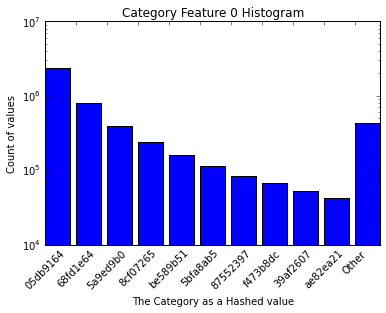

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [547518, 206093, 182640, 172943, 169845, 154653, 150864, 124409, 113784, 107886, 2844208]
X: 11, Y: 11


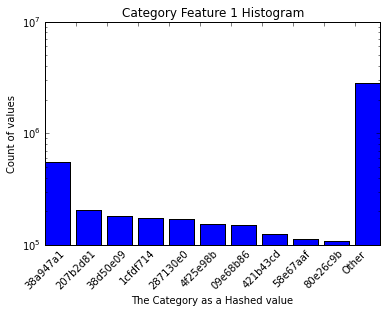

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [162279, 119226, 51420, 47498, 47026, 41324, 39637, 37791, 36775, 34941, 4156926]
X: 11, Y: 11


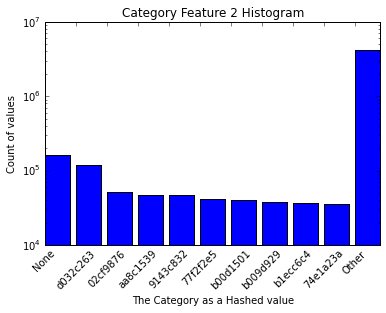

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [170657, 162279, 103597, 101706, 92711, 89292, 71774, 47026, 42472, 37884, 3855445]
X: 11, Y: 11


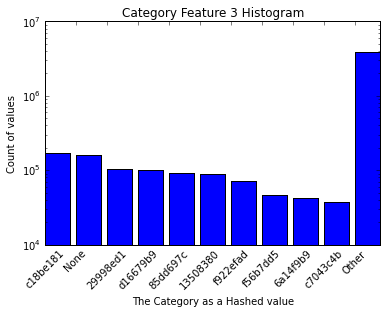

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [3205078, 747363, 301755, 156272, 92144, 59909, 41138, 28764, 22338, 16994, 103088]
X: 11, Y: 11


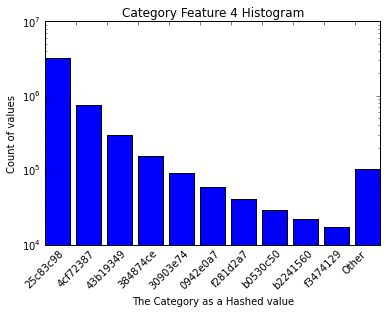

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [1892360, 1039460, 887939, 578036, 151813, 136090, 87494, 743, 433, 221, 254]
X: 11, Y: 11


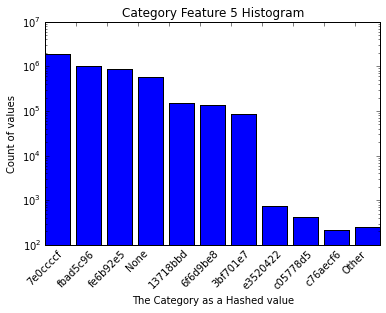

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [99564, 60000, 42476, 36756, 36510, 34856, 30552, 27372, 27353, 26201, 4353203]
X: 11, Y: 11


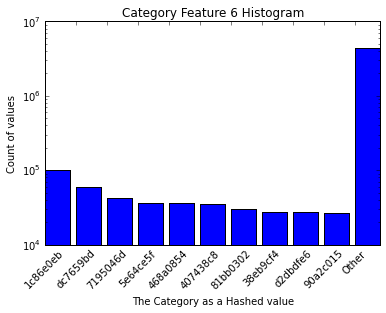

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [2835135, 794919, 357946, 199007, 124154, 85294, 59587, 45218, 34418, 28850, 210315]
X: 11, Y: 11


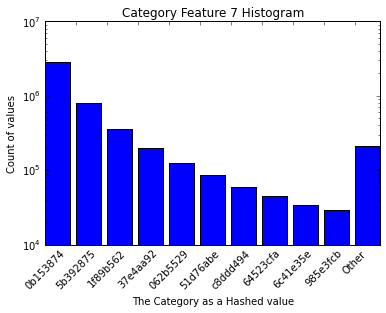

X: [ 0  1  2 10], Y: [4291736, 482368, 739, 0]
X: 4, Y: 4


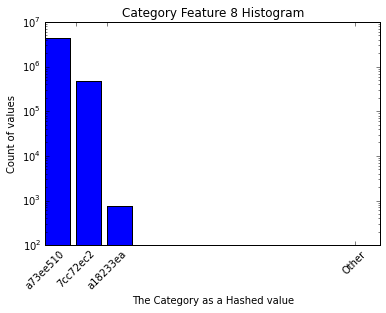

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [1059735, 70440, 36481, 27419, 25556, 23418, 21464, 19235, 19025, 17940, 3454130]
X: 11, Y: 11


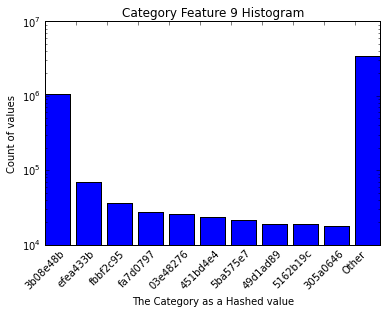

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [151826, 99805, 71781, 62062, 52490, 44039, 41208, 37258, 37002, 34834, 4142538]
X: 11, Y: 11


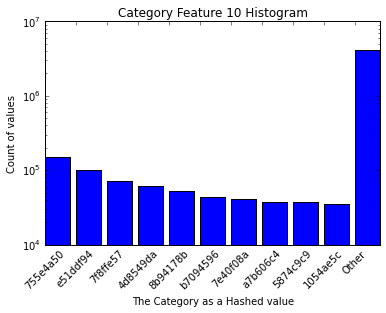

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [162279, 119226, 103597, 51420, 47498, 47026, 41324, 39637, 37791, 36775, 4088270]
X: 11, Y: 11


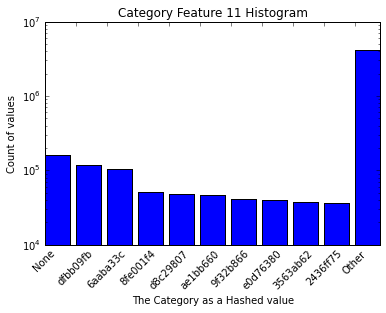

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [151826, 111612, 78690, 67953, 63590, 62062, 58585, 45506, 44039, 37355, 4053625]
X: 11, Y: 11


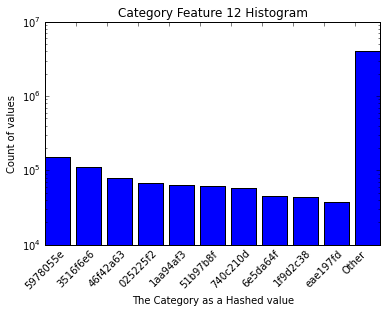

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [1670292, 1638515, 736829, 211275, 145160, 115884, 62443, 56289, 35686, 28019, 74451]
X: 11, Y: 11


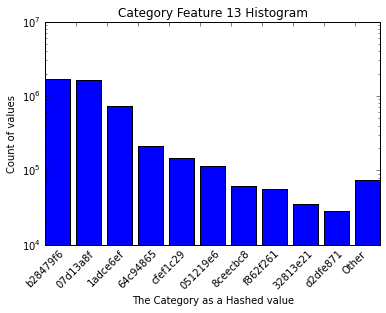

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [71041, 49404, 44000, 42443, 39813, 38315, 38191, 38127, 37573, 37015, 4338921]
X: 11, Y: 11


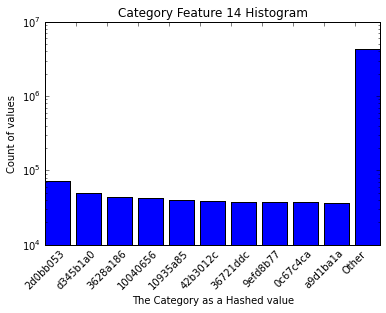

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [162279, 119231, 103597, 51420, 47498, 47026, 42137, 41389, 39637, 37791, 4082838]
X: 11, Y: 11


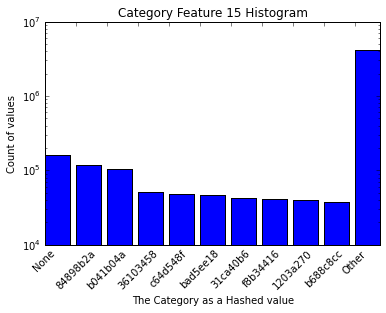

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [2203554, 623582, 547988, 399429, 251254, 216977, 204895, 203281, 123734, 149, 0]
X: 11, Y: 11


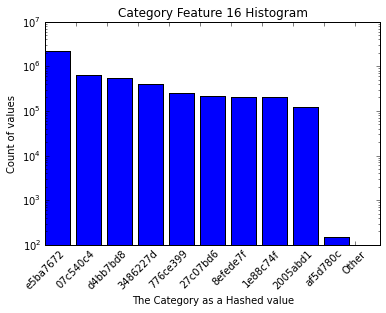

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [150747, 135293, 124407, 113784, 103505, 93191, 91421, 87922, 80773, 48860, 3744940]
X: 11, Y: 11


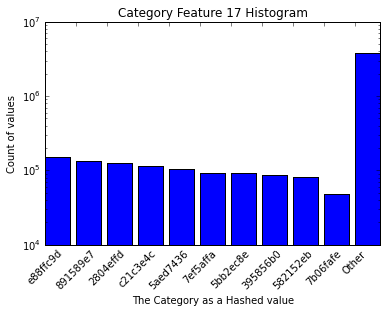

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [2102652, 1644569, 93271, 38218, 35123, 27902, 27470, 24028, 19290, 13977, 748343]
X: 11, Y: 11


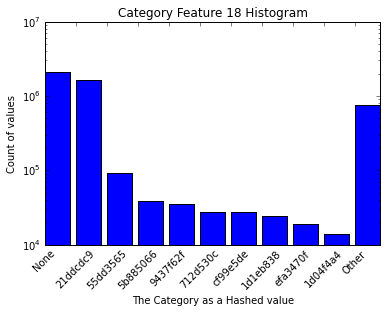

X: [ 0  1  2  3 10], Y: [2102652, 904765, 889086, 878340, 0]
X: 5, Y: 5


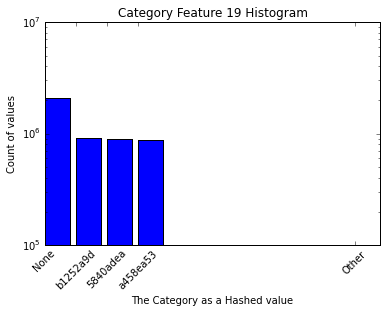

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [162279, 119226, 103597, 51420, 47498, 47026, 41389, 41324, 39637, 37791, 4083656]
X: 11, Y: 11


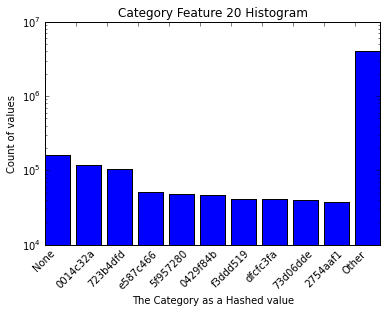

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [3641075, 650749, 400923, 34955, 25188, 19105, 1270, 977, 486, 56, 59]
X: 11, Y: 11


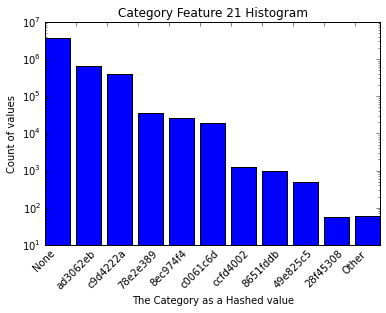

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [2101533, 957154, 575061, 331786, 269913, 267299, 114358, 72070, 40268, 21756, 23645]
X: 11, Y: 11


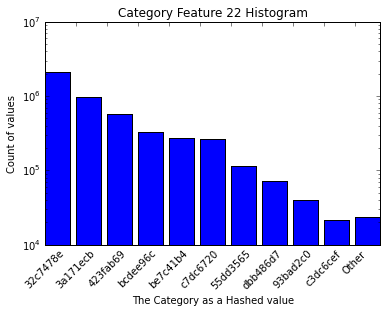

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [250403, 225994, 218855, 206593, 162279, 105179, 104919, 96586, 80219, 67825, 3255991]
X: 11, Y: 11


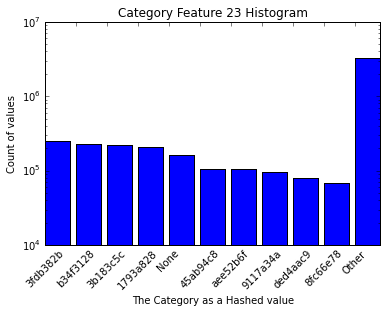

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [2102652, 681807, 519364, 381732, 188937, 148986, 148554, 147377, 139776, 98695, 216963]
X: 11, Y: 11


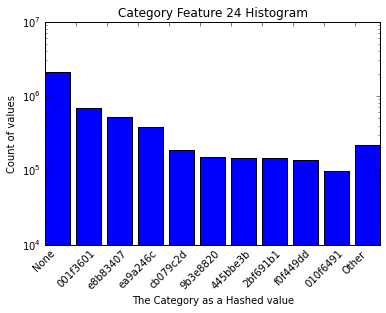

X: [ 0  1  2  3  4  5  6  7  8  9 10], Y: [2102652, 196854, 89296, 75834, 70662, 66597, 51955, 40757, 39513, 34654, 2006069]
X: 11, Y: 11


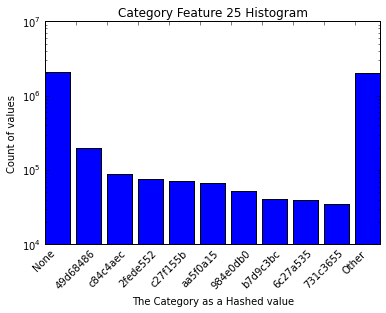

In [16]:
# Compute and display Category Histograms
hashes, counts, remainder =cat_columns_histogram(train_5m)
show_all_histograms(hashes, counts,"Category",remainder)